<a href="https://colab.research.google.com/github/Thanchanokning/229352/blob/main/Copy_of_Lab09_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #9

In [ ]:
%%capture
!git clone https://github.com/donlapark/ds352-labs.git

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

## Training a neural network in PyTorch

### Chihuahua or Muffin?

<center><img src="https://donlapark.pages.dev/229352/lab09-preview.jpg" width="500"/></center>

### 1. Data preparation

#### Load images, resize them to 128x128, and normalize the pixels to be in 0 - 1 range

In [ ]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])  # transform pixels to be in 0 - 1 range

dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/train",
                                         transform=transform)

#### Split the dataset into training (80%), validation (20%)

In [ ]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#### Load the datasets into DataLoader

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=10, # 1 batch = 10 images
                          shuffle=True) # Shuffle
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=len(val_dataset),
                        shuffle=False)

#### Do the same for the test images

In [ ]:
test_dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/test",
                                    transform=transform)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=len(test_dataset),
                         shuffle=False)

#### Looking at the first minibatch

In [ ]:
# ใช้นอก loop (ใช้ for loop ได้)
train_batches = iter(train_loader)
X, y = next(train_batches)

print(X.shape)  # (batch_size, channel, height, weight)
print(y.shape) # Label

torch.Size([10, 3, 128, 128])
torch.Size([10])


#### Visualize the first four images in the batch

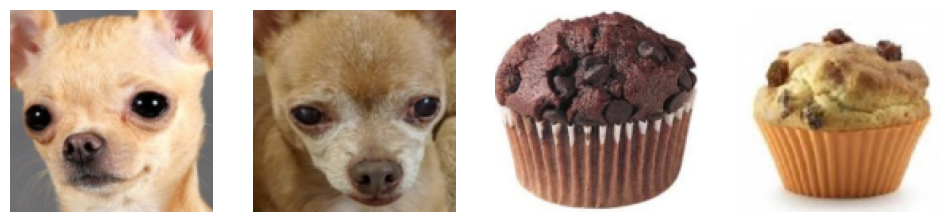

tensor([0, 0, 1, 1])


In [ ]:
X = X[:4]  # Select the first 4 images on training set
X = X.numpy().transpose(0, 2, 3, 1)  # Convert from (B, C, H, W) to (B, H, W, C)

# Plot images and label
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    axes[i].imshow(X[i])
    axes[i].axis('off')
plt.show()

print(y[:4])

### 2. Build a simple logistic regression

<center><img src="https://donlapark.pages.dev/229352/logistic.png" width="300"/></center>

The most important component of the model class is the `__init__` method and the `forward` method.  
  
[Activation functions in PyTorch](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). The most important ones are [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html), [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html).

In [ ]:
class SimpleLogisticRegression(nn.Module): # Model class
# Attribute --> Layers
  def __init__(self):
    super().__init__()
    # Define layers
    self.flatten = nn.Flatten() # คลี่รูปภาพ
    # linear layer
    self.lin1 = nn.Linear(128 * 128 * 3, 100) # input ตัวที่สองมีความยาว 100
    self.act1 = nn.ReLU() # Activation function
    self.lin2 = nn.Linear(100, 50)
    self.act2 = nn.ReLU() # Activation function
    self.lin3 = nn.Linear(50, 1)

# init เชื่อมต่อกันอย่างไรบ้าง
  def forward(self, x):
    # Forward pass ข้อมูลต้องผ่านตังไหนบ้าง
    x = self.flatten(x)
    x = self.lin1(x)
    x = self.act1(x)
    x = self.lin2(x)
    x = self.act2(x)
    x = self.lin3(x)
    return x

### 3. Initialize training components

#### Initialize the model and loss function

[Loss functions in PyTorch](https://pytorch.org/docs/stable/nn.html#loss-functions). Most important ones are [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html), [Binary cross, entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), [Categorical cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [ ]:
model = SimpleLogisticRegression()
criterion = nn.CrossEntropyLoss()

#### Manually setting initial weights to zero for demonstration

In [ ]:
with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_() # Parameter's weight = 0
          layer.bias.zero_()

#### Create two lists to collect training and validation losses

In [ ]:
# List to store the loss values for plotting
train_losses = []
val_losses = []

#### Specify the learning rate

In [ ]:
learning_rate = 1e-3
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

### 4. Training the model with gradient descent

#### Convert the dataloader into minibatches

In [ ]:
X, y = next(train_batches) # X : images, y : labels

#### Make a prediction on the minibatch (Forward pass)

In [ ]:
y_hat = model(X)
y = y.to(torch.float32)
# Output ---> vector ---> Scalar
y_hat = y_hat[:, 0]

#y_hat = y_hat[:, 0]
#y = y.to(torch.float32)

#### Calculate the loss function

Recall that `criterion()` is our binary cross-entropy loss (`BCELoss`).

In [ ]:
# Compute the loss
train_loss = criterion(y_hat, y)
train_losses.append(train_loss)

In [ ]:
train_losses

[tensor(9.2103, grad_fn=<DivBackward1>)]

#### Calculate the gradient (Backward pass)

In [ ]:
# Backward pass: compute the gradient of the loss w.r.t. model parameters
train_loss.backward()

In [ ]:
model.parameters()

<generator object Module.parameters at 0x7ac63d5cb760>

#### Perform a gradient descent step

Careful! We must not include this step in the gradient calculation, hence the use of `with torch.no_grad()`.

In [ ]:
# Manually update the weights using the gradient descent rule
optimizer.step() # parameter - learning_rate

# Zero the gradients after updating
model.zero_grad()

#### Do the same for the validation set

Careful! Anything in the validation step must not be included in the gradient calculation, hence the use of `with torch.no_grad()`.

In [ ]:
with torch.no_grad():
  for X, y in val_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)
    val_loss = criterion(y_hat, y)
    val_losses.append(val_loss.item())

In [ ]:
print(train_losses)
print(val_losses)

[tensor(9.2103, grad_fn=<DivBackward1>)]
[57.2049674987793]


#### Combine everything together.

Repeat the previous steps for 20 **epochs** and plot the training and validation losses.

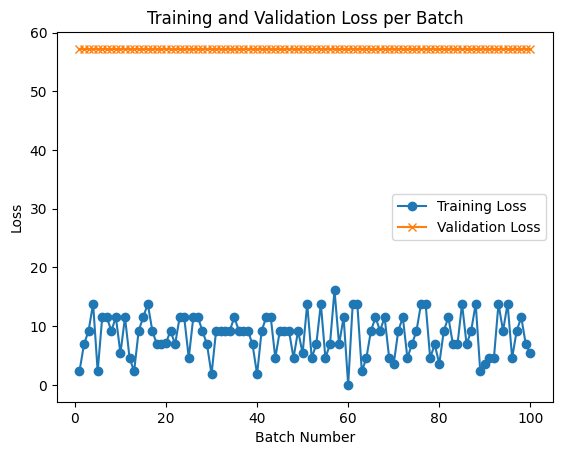

In [ ]:
model = SimpleLogisticRegression()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

train_losses = []
val_losses = []

learning_rate = 1e-4

for epoch in range(10):
  for X, y in train_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)

    loss = criterion(y_hat, y)
    train_losses.append(loss.item())

    loss.backward()
    optimizer.step()

    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

    # Zero the gradients after updating
    model.zero_grad()

    with torch.no_grad():
      for X, y in val_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)
        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss)

# Plot the training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exercise

In this exercise, we will add more layers to our classification model.

<img src="https://donlapark.pages.dev/229352/lab09-architecture.png" width="450"/>

1. Create a neural network with 3 hidden layers as shown in the picture.

2. Train the model with learning rate = 1e-2, 1e-3, 1e-4, 1e-5, and answer the following questions.
    2.1 What value of learning rate do you **think** is the best? Please explain your reason.
    2.2 What happens to the training losses if your learning rate is too large?
    2.3 What happens to the training losses if your learning rate is too small?

3. After finish training your model. Make the predictions on the test set and compute the accuracy. You may use the provided code below.

4. Use `plt.imshow()` to display at least four images that are incorrectly classified by this model.

In [ ]:
# Create a neural network with 3 hidden layers as shown in the picture.
class SimpleLogisticRegression(nn.Module): # Model class
# Attribute --> Layers
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.lin1 = nn.Linear(128 * 128 * 3, 128)
    self.act1 = nn.ReLU()
    self.lin2 = nn.Linear(128, 64)
    self.act2 = nn.ReLU()
    self.lin3 = nn.Linear(64, 32)
    self.act3 = nn.ReLU()
    self.lin4 = nn.Linear(32, 1)

# init เชื่อมต่อกันอย่างไรบ้าง
  def forward(self, x):
    # Forward pass ข้อมูลต้องผ่านตังไหนบ้าง
    x = self.flatten(x)
    x = self.lin1(x)
    x = self.act1(x)
    x = self.lin2(x)
    x = self.act2(x)
    x = self.lin3(x)
    x = self.act3(x)
    x = self.lin4(x)
    return x

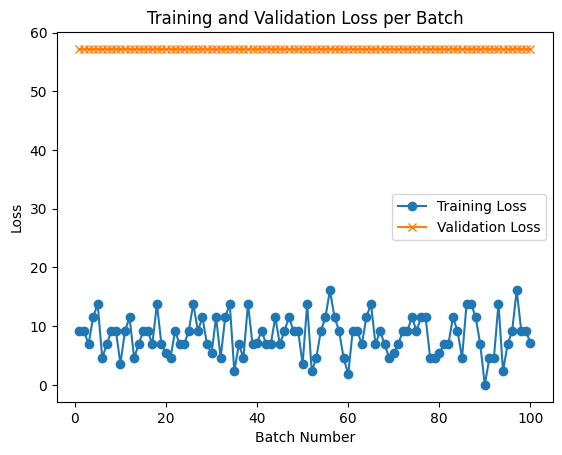

[9.21034049987793, 9.21034049987793, 6.907755374908447, 11.51292610168457, 13.815511703491211, 4.605170249938965, 6.907755374908447, 9.21034049987793, 9.21034049987793, 3.5835189819335938, 9.21034049987793, 11.51292610168457, 4.605170249938965, 6.907755374908447, 9.21034049987793, 9.21034049987793, 6.907755374908447, 13.815511703491211, 6.907755374908447, 5.375278472900391, 4.605170249938965, 9.21034049987793, 6.907755374908447, 6.907755374908447, 9.21034049987793, 13.815511703491211, 9.21034049987793, 11.51292610168457, 6.907755374908447, 5.375278472900391, 11.51292610168457, 4.605170249938965, 11.51292610168457, 13.815511703491211, 2.3025851249694824, 6.907755374908447, 4.605170249938965, 13.815511703491211, 6.907755374908447, 7.1670379638671875, 9.21034049987793, 6.907755374908447, 6.907755374908447, 11.51292610168457, 6.907755374908447, 9.21034049987793, 11.51292610168457, 9.21034049987793, 9.21034049987793, 3.5835189819335938, 13.815511703491211, 2.3025851249694824, 4.605170249938

In [ ]:
# Train the model with learning rate
# lr = 1e-2
model = SimpleLogisticRegression()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

train_losses = []
val_losses = []

for epoch in range(10):
  for X, y in train_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)

    loss = criterion(y_hat, y)
    train_losses.append(loss.item())

    loss.backward()
    optimizer.step()

    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

    # Zero the gradients after updating
    model.zero_grad()

    with torch.no_grad():
      for X, y in val_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)
        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss)

# Plot the training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()
print(train_losses)
print(val_losses)

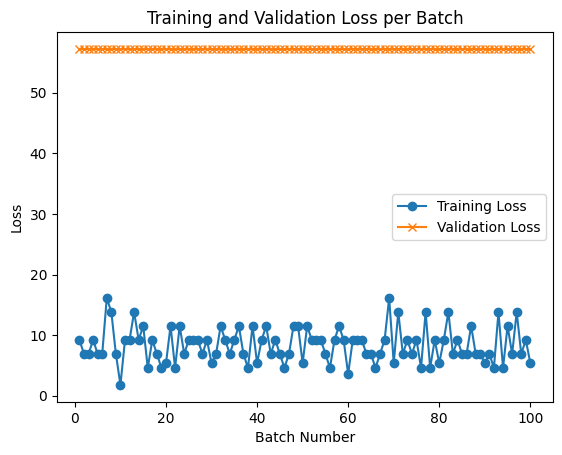

[9.21034049987793, 6.907755374908447, 6.907755374908447, 9.21034049987793, 6.907755374908447, 6.907755374908447, 16.11809730529785, 13.815511703491211, 6.907755374908447, 1.7917594909667969, 9.21034049987793, 9.21034049987793, 13.815511703491211, 9.21034049987793, 11.51292610168457, 4.605170249938965, 9.21034049987793, 6.907755374908447, 4.605170249938965, 5.375278472900391, 11.51292610168457, 4.605170249938965, 11.51292610168457, 6.907755374908447, 9.21034049987793, 9.21034049987793, 9.21034049987793, 6.907755374908447, 9.21034049987793, 5.375278472900391, 6.907755374908447, 11.51292610168457, 9.21034049987793, 6.907755374908447, 9.21034049987793, 11.51292610168457, 6.907755374908447, 4.605170249938965, 11.51292610168457, 5.375278472900391, 9.21034049987793, 11.51292610168457, 6.907755374908447, 9.21034049987793, 6.907755374908447, 4.605170249938965, 6.907755374908447, 11.51292610168457, 11.51292610168457, 5.375278472900391, 11.51292610168457, 9.21034049987793, 9.21034049987793, 9.210

In [ ]:
# Train the model with learning rate
# lr = 1e-3
model = SimpleLogisticRegression()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

train_losses = []
val_losses = []

for epoch in range(10):
  for X, y in train_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)

    loss = criterion(y_hat, y)
    train_losses.append(loss.item())

    loss.backward()
    optimizer.step()

    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

    # Zero the gradients after updating
    model.zero_grad()

    with torch.no_grad():
      for X, y in val_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)
        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss)

# Plot the training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()
print(train_losses)
print(val_losses)

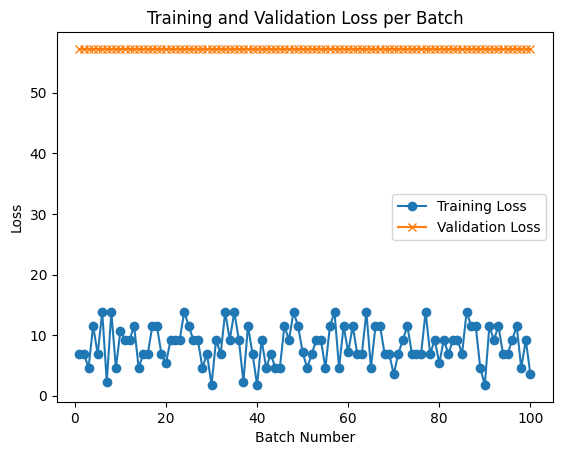

[6.907755374908447, 6.907755374908447, 4.605170249938965, 11.51292610168457, 6.907755374908447, 13.815511703491211, 2.3025851249694824, 13.815511703491211, 4.605170249938965, 10.750556945800781, 9.21034049987793, 9.21034049987793, 11.51292610168457, 4.605170249938965, 6.907755374908447, 6.907755374908447, 11.51292610168457, 11.51292610168457, 6.907755374908447, 5.375278472900391, 9.21034049987793, 9.21034049987793, 9.21034049987793, 13.815511703491211, 11.51292610168457, 9.21034049987793, 9.21034049987793, 4.605170249938965, 6.907755374908447, 1.7917594909667969, 9.21034049987793, 6.907755374908447, 13.815511703491211, 9.21034049987793, 13.815511703491211, 9.21034049987793, 2.3025851249694824, 11.51292610168457, 6.907755374908447, 1.7917594909667969, 9.21034049987793, 4.605170249938965, 6.907755374908447, 4.605170249938965, 4.605170249938965, 11.51292610168457, 9.21034049987793, 13.815511703491211, 11.51292610168457, 7.1670379638671875, 4.605170249938965, 6.907755374908447, 9.210340499

In [ ]:
# Train the model with learning rate
# lr = 1e-4
model = SimpleLogisticRegression()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

train_losses = []
val_losses = []

for epoch in range(10):
  for X, y in train_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)

    loss = criterion(y_hat, y)
    train_losses.append(loss.item())

    loss.backward()
    optimizer.step()

    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

    # Zero the gradients after updating
    model.zero_grad()

    with torch.no_grad():
      for X, y in val_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)
        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss)

# Plot the training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()
print(train_losses)
print(val_losses)

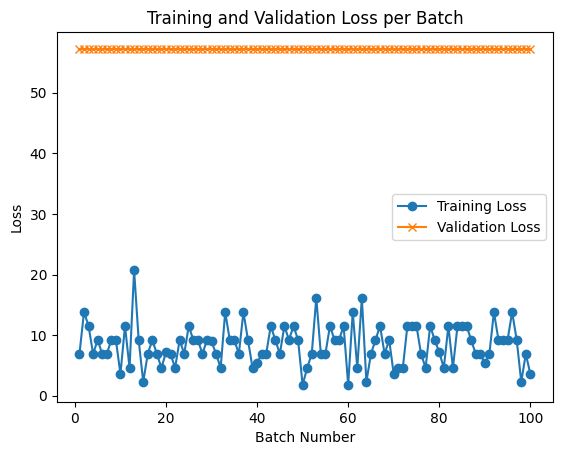

[6.907755374908447, 13.815511703491211, 11.51292610168457, 6.907755374908447, 9.21034049987793, 6.907755374908447, 6.907755374908447, 9.21034049987793, 9.21034049987793, 3.5835189819335938, 11.51292610168457, 4.605170249938965, 20.723268508911133, 9.21034049987793, 2.3025851249694824, 6.907755374908447, 9.21034049987793, 6.907755374908447, 4.605170249938965, 7.1670379638671875, 6.907755374908447, 4.605170249938965, 9.21034049987793, 6.907755374908447, 11.51292610168457, 9.21034049987793, 9.21034049987793, 6.907755374908447, 9.21034049987793, 8.958797454833984, 6.907755374908447, 4.605170249938965, 13.815511703491211, 9.21034049987793, 9.21034049987793, 6.907755374908447, 13.815511703491211, 9.21034049987793, 4.605170249938965, 5.375278472900391, 6.907755374908447, 6.907755374908447, 11.51292610168457, 9.21034049987793, 6.907755374908447, 11.51292610168457, 9.21034049987793, 11.51292610168457, 9.21034049987793, 1.7917594909667969, 4.605170249938965, 6.907755374908447, 16.11809730529785,

In [ ]:
# Train the model with learning rate
# lr = 1e-5
model = SimpleLogisticRegression()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)

with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

train_losses = []
val_losses = []

for epoch in range(10):
  for X, y in train_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)

    loss = criterion(y_hat, y)
    train_losses.append(loss.item())

    loss.backward()
    optimizer.step()

    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

    # Zero the gradients after updating
    model.zero_grad()

    with torch.no_grad():
      for X, y in val_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)
        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss)

# Plot the training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()
print(train_losses)
print(val_losses)

2.1 What value of learning rate do you think is the best? Please explain your reason.

1e-02 เป็น learning rate ที่ดีที่สุด หากพิจารณาจากกราฟแต่ละกราฟ พบว่าค่า training loss ในแต่ละ batch ของ learning rate = 1e-02 ส่วนใหญ่มีค่าน้อย

2.2 What happens to the training losses if your learning rate is too large?

ถ้า learning rate มีค่ามากเกินไป จะทำให้แต่ละ batch มีค่า training losses มาก เนื่องจากการอัพเดตค่าพารามิเตอร์อาจข้ามค่าของ loss function ที่ต่ำที่สุด

2.3 What happens to the training losses if your learning rate is too small?

ถ้า learning rate มีค่าน้อยเกินไป จะทำให้แต่ละ batch มีค่า training losses มาก เนื่องจากการอัพเดตค่าพารามิเตอร์ในแต่ละ batch อาจทำให้ค่า training loss ไม่ถึงจุดต่ำสุด

In [ ]:
# After finish training your model. Make the predictions on the test set and compute the accuracy. You may use the provided code below.
# Test set
test_losses = []
criterion = nn.CrossEntropyLoss()
with torch.no_grad():
  test_batches = iter(test_loader)
  X, y = next(test_batches)
  y_hat = model(X)
  y_hat = y_hat[:, 0]
  y_hat = (y_hat > 0.5).float()
  y = y.to(torch.float32)
  test_loss = criterion(y_hat, y)
  test_losses.append(test_loss)

print(test_losses)

[tensor(44.2156)]


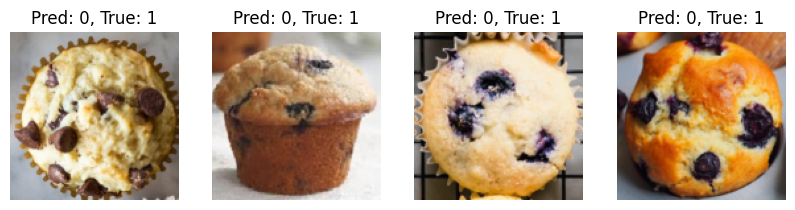

In [ ]:
import matplotlib.pyplot as plt
import torch

model.eval()

misclassified_images = []
misclassified_preds = []
misclassified_labels = []

with torch.no_grad():
    for X, y in test_loader:
        logits = model(X).squeeze(1)
        preds = (torch.sigmoid(logits) > 0.5).float()

        for i in range(len(y)):
            if preds[i] != y[i]:
                misclassified_images.append(X[i])
                misclassified_preds.append(preds[i].item())
                misclassified_labels.append(y[i].item())

            if len(misclassified_images) >= 4:
                break
        if len(misclassified_images) >= 4:
            break

plt.figure(figsize=(10, 4))

for i in range(4):
    plt.subplot(1, 4, i + 1)

    img = misclassified_images[i]

    # ถ้าเป็น grayscale (C=1)
    if img.shape[0] == 1:
        plt.imshow(img.squeeze(0), cmap="gray")
    else:
        # (C, H, W) → (H, W, C)
        plt.imshow(img.permute(1, 2, 0))

    plt.title(f"Pred: {int(misclassified_preds[i])}, True: {int(misclassified_labels[i])}")
    plt.axis("off")

plt.show()
